In [3]:
##### Code to test difference in hourly mean values when sensor logging intervals are 10 mins vs 20 mins ######

# Read in the packages to use
import numpy as np
import pandas as pd
import datetime
from datetime import datetime, timedelta
import os
import pathlib
import matplotlib.pyplot as plt
import earthpy as et
import scipy.stats as stats
#import statsmodels.api as sm

# load in the calibration data
os.chdir(os.path.join(et.io.HOME, 'DDL')) ## ..... CHANGE TO DIRECTORY WHERE DATA STORED
calibration_4_shield_on_data = pd.read_csv('Calibration_4_Shield_on_Data_cleaned_const_timeseries.csv') # calibration 4 shield on data 

# get the date time column into the correct format
calibration_4_shield_on_data['Date_Time_Format'] = calibration_4_shield_on_data.apply(lambda row: datetime.strptime(row.Date_Time_Format, '%Y-%m-%d %H:%M:%S'), axis=1)
# add time column 
calibration_4_shield_on_data['Time_of_Day'] = calibration_4_shield_on_data.apply(lambda row: row.Date_Time_Format.strftime("%H:%M"), axis=1)
# convert to celcius (if required)
# °C = (°F - 32) × 5/9
degrees = 'C'
if degrees == 'C':
    calibration_4_shield_on_data['Temperature'] = (5/9)*(calibration_4_shield_on_data['Temperature'] - 32)

## when the sensor has gaps in the data, fill these in by using the mean of the other sensors
## the gaps can lead to issues as there will be some daily means which do not have all the days included 

# get the sensors which have missing data
sensors_with_nans =list(set(calibration_4_shield_on_data[(np.isnan(calibration_4_shield_on_data.Temperature))].Sensor_ID))

for sensor_id in sensors_with_nans:
    # get the dates and times which have no measurements
    dates = calibration_4_shield_on_data[(np.isnan(calibration_4_shield_on_data.Temperature))&(calibration_4_shield_on_data.Sensor_ID == sensor_id
                                                                                                )].Date_Time_Format.values
    for date in dates:
        # get the mean temperature for that date and time
        mean_temp = calibration_4_shield_on_data[~(np.isnan(calibration_4_shield_on_data.Temperature))&(
            calibration_4_shield_on_data.Date_Time_Format == date)].Temperature.mean()

        # update to add in the mean temperature as the main one for this time
        calibration_4_shield_on_data.loc[(calibration_4_shield_on_data.Date_Time_Format == date)&(
            calibration_4_shield_on_data.Sensor_ID == sensor_id  ), 'Temperature'] = mean_temp

## Custom hour - averaging based on +/- 30 mins from the hour (centred on the hour)
## can investigate the impact of changing this 
def custom_hour(df, column_name):
    df['hour'] = df[column_name].dt.hour
    df['minute'] = df[column_name].dt.minute
    df['date'] = df['Date_Time_Format'].dt.date #get the date (add one to the date if 11:30 or after)
    df['Custom_Hour'] = df['hour'] + df['minute'].apply(lambda x: 1 if x >= 30 else 0)
    # when the hour is 24, create a date which is the next day
    df['date2'] = pd.to_datetime(df['date']) + timedelta(days=1) * df['Custom_Hour'].apply(lambda x: 1 if x == 24 else 0)
    # convert the hour to 0 if it is 24
    df['Custom_Hour'] = df['Custom_Hour'] * df['Custom_Hour'].apply(lambda x: 0 if x == 24 else 1)
    return df['Custom_Hour']

# add custom hour to the df
calibration_4_shield_on_data['Custom_Hour'] = custom_hour(calibration_4_shield_on_data, 'Date_Time_Format')
calibration_4_shield_on_data['Custom_Hour'] = calibration_4_shield_on_data.apply(lambda row: datetime.strptime(str(row.Custom_Hour).zfill(2), '%H').strftime("%H:%M"), axis=1)


In [5]:
calibration_4_shield_on_data_20_min = calibration_4_shield_on_data[(calibration_4_shield_on_data["minute"] == 0) |(calibration_4_shield_on_data["minute"] == 20) |(calibration_4_shield_on_data["minute"] == 40)]
calibration_4_shield_on_data_30_min = calibration_4_shield_on_data[(calibration_4_shield_on_data["minute"] == 0) |(calibration_4_shield_on_data["minute"] == 30)]

In [6]:
## Remove 10s etc to only get every 20 minute readings (and same for 30 mins)

## compare mean temp for 10 minutes vs 20 minutes vs 30 minutes

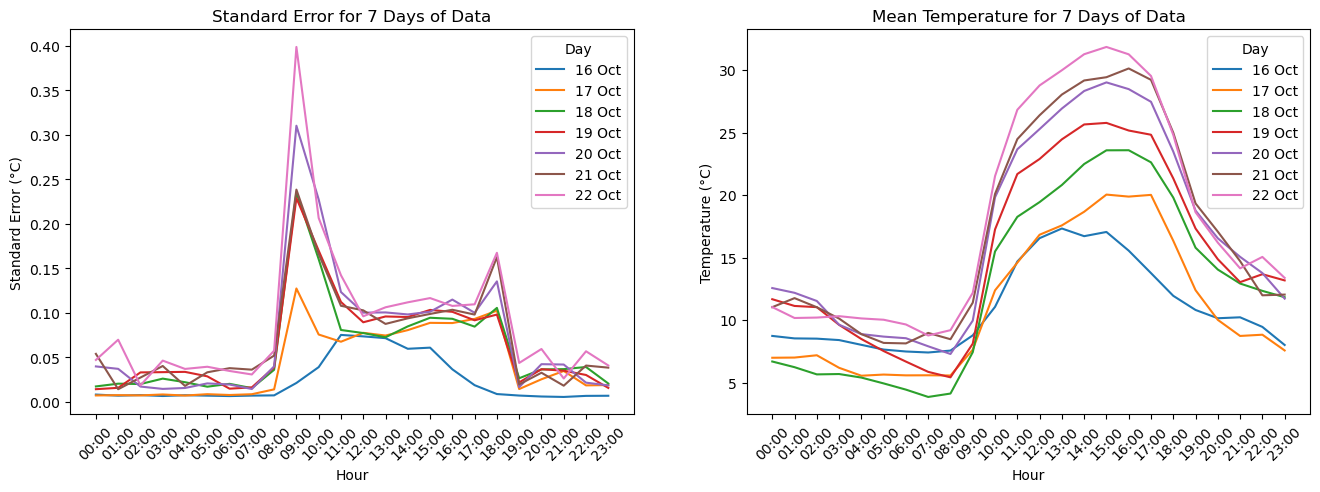

In [7]:
fig, axes = plt.subplots(1,2,figsize = (16,5))

idx_days = range(7) 

calibration_4_shield_on_intervals = pd.DataFrame()

for idx_day in idx_days:
    start_date = datetime.strptime('2024-10-{} 23:30:00'.format(idx_day+15), '%Y-%m-%d %H:%M:%S')
    end_date = datetime.strptime('2024-10-{} 23:30:00'.format(idx_day+16), '%Y-%m-%d %H:%M:%S')
    
    calibration_dataframe = calibration_4_shield_on_data[(calibration_4_shield_on_data.Date_Time_Format > start_date) & (
                                calibration_4_shield_on_data.Date_Time_Format < end_date)]
    
    hourly_means = calibration_dataframe.groupby(['Sensor_ID','Custom_Hour']).mean(numeric_only = True).reset_index()

    means = hourly_means.groupby('Custom_Hour').mean(numeric_only = True).reset_index(
                            )[['Custom_Hour', 'Temperature']].rename(columns ={ 'Temperature':'Temperature_Mean'})

    stds = hourly_means.groupby('Custom_Hour').std(numeric_only = True).reset_index(
                            )[['Custom_Hour', 'Temperature']].rename(columns ={ 'Temperature':'Temperature_Std'})

    mins = hourly_means.groupby('Custom_Hour').min(numeric_only = True).reset_index(
                            )[['Custom_Hour', 'Temperature']].rename(columns ={ 'Temperature':'Temperature_Min'})

    maxs = hourly_means.groupby('Custom_Hour').max(numeric_only = True).reset_index(
                            )[['Custom_Hour', 'Temperature']].rename(columns ={ 'Temperature':'Temperature_Max'})

    
    axes[0].plot(stds.Custom_Hour, stds.Temperature_Std/ np.sqrt(41), label = '{} Oct'.format(idx_day+16))
    axes[1].plot(means.Custom_Hour, means.Temperature_Mean, label = '{} Oct'.format(idx_day+16))
    
    temp_df = pd.merge(means, stds, on = 'Custom_Hour', how = 'inner')
    temp_df['Day'] = '{}_Oct'.format(idx_day+16)
    calibration_4_shield_on_intervals = pd.concat([calibration_4_shield_on_intervals,temp_df])
#calibration_4_shield_on_data

axes[0].set(title = 'Standard Error for 7 Days of Data', xlabel= 'Hour', ylabel='Standard Error (\u00B0C)')
axes[1].set(title = 'Mean Temperature for 7 Days of Data', xlabel= 'Hour', ylabel='Temperature (\u00B0C)')
axes[0].legend(title = 'Day')
axes[1].legend(title = 'Day')

axes[0].tick_params(axis='x', labelrotation=45)
axes[1].tick_params(axis='x', labelrotation=45)

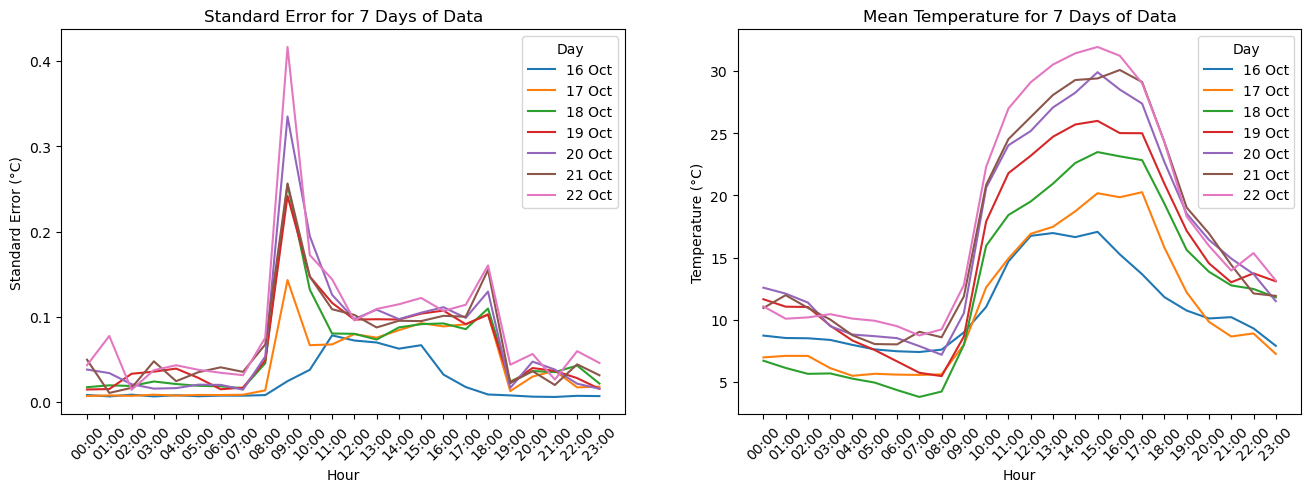

In [8]:
fig, axes = plt.subplots(1,2,figsize = (16,5))

idx_days = range(7) 

calibration_4_shield_on_intervals = pd.DataFrame()

for idx_day in idx_days:
    start_date = datetime.strptime('2024-10-{} 23:30:00'.format(idx_day+15), '%Y-%m-%d %H:%M:%S')
    end_date = datetime.strptime('2024-10-{} 23:30:00'.format(idx_day+16), '%Y-%m-%d %H:%M:%S')
    
    calibration_dataframe = calibration_4_shield_on_data_20_min[(calibration_4_shield_on_data_20_min.Date_Time_Format > start_date) & (
                                calibration_4_shield_on_data_20_min.Date_Time_Format < end_date)]
    
    hourly_means = calibration_dataframe.groupby(['Sensor_ID','Custom_Hour']).mean(numeric_only = True).reset_index()

    means = hourly_means.groupby('Custom_Hour').mean(numeric_only = True).reset_index(
                            )[['Custom_Hour', 'Temperature']].rename(columns ={ 'Temperature':'Temperature_Mean'})

    stds = hourly_means.groupby('Custom_Hour').std(numeric_only = True).reset_index(
                            )[['Custom_Hour', 'Temperature']].rename(columns ={ 'Temperature':'Temperature_Std'})

    mins = hourly_means.groupby('Custom_Hour').min(numeric_only = True).reset_index(
                            )[['Custom_Hour', 'Temperature']].rename(columns ={ 'Temperature':'Temperature_Min'})

    maxs = hourly_means.groupby('Custom_Hour').max(numeric_only = True).reset_index(
                            )[['Custom_Hour', 'Temperature']].rename(columns ={ 'Temperature':'Temperature_Max'})

    
    axes[0].plot(stds.Custom_Hour, stds.Temperature_Std/ np.sqrt(41), label = '{} Oct'.format(idx_day+16))
    axes[1].plot(means.Custom_Hour, means.Temperature_Mean, label = '{} Oct'.format(idx_day+16))
    
    temp_df = pd.merge(means, stds, on = 'Custom_Hour', how = 'inner')
    temp_df['Day'] = '{}_Oct'.format(idx_day+16)
    calibration_4_shield_on_intervals = pd.concat([calibration_4_shield_on_intervals,temp_df])
#calibration_4_shield_on_data

axes[0].set(title = 'Standard Error for 7 Days of Data', xlabel= 'Hour', ylabel='Standard Error (\u00B0C)')
axes[1].set(title = 'Mean Temperature for 7 Days of Data', xlabel= 'Hour', ylabel='Temperature (\u00B0C)')
axes[0].legend(title = 'Day')
axes[1].legend(title = 'Day')

axes[0].tick_params(axis='x', labelrotation=45)
axes[1].tick_params(axis='x', labelrotation=45)

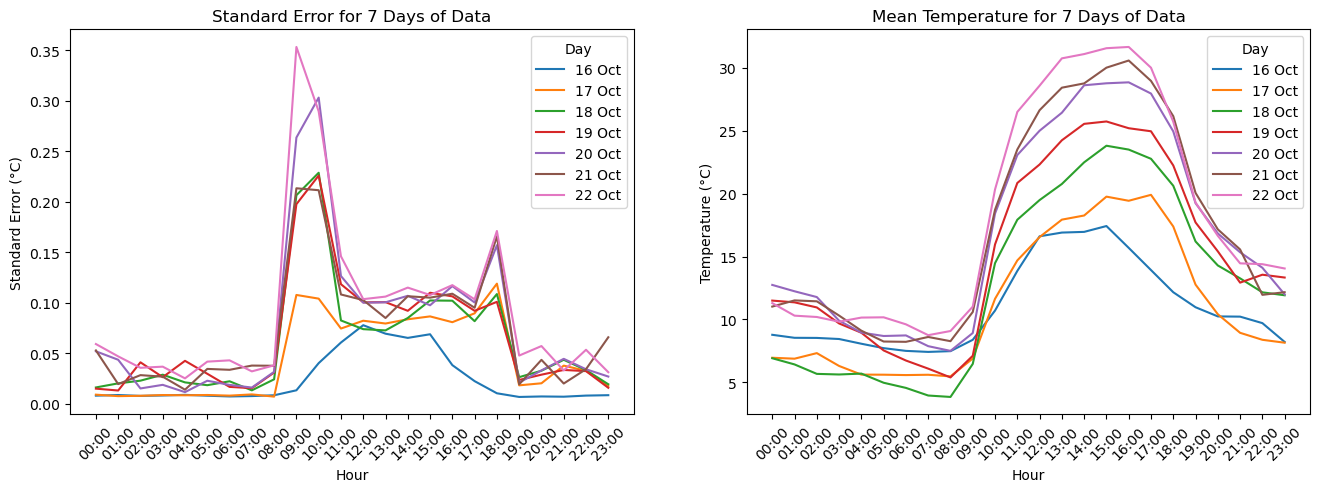

In [9]:
fig, axes = plt.subplots(1,2,figsize = (16,5))

idx_days = range(7) 

calibration_4_shield_on_intervals = pd.DataFrame()

for idx_day in idx_days:
    start_date = datetime.strptime('2024-10-{} 23:30:00'.format(idx_day+15), '%Y-%m-%d %H:%M:%S')
    end_date = datetime.strptime('2024-10-{} 23:30:00'.format(idx_day+16), '%Y-%m-%d %H:%M:%S')
    
    calibration_dataframe = calibration_4_shield_on_data_30_min[(calibration_4_shield_on_data_30_min.Date_Time_Format > start_date) & (
                                calibration_4_shield_on_data_30_min.Date_Time_Format < end_date)]
    
    hourly_means = calibration_dataframe.groupby(['Sensor_ID','Custom_Hour']).mean(numeric_only = True).reset_index()

    means = hourly_means.groupby('Custom_Hour').mean(numeric_only = True).reset_index(
                            )[['Custom_Hour', 'Temperature']].rename(columns ={ 'Temperature':'Temperature_Mean'})

    stds = hourly_means.groupby('Custom_Hour').std(numeric_only = True).reset_index(
                            )[['Custom_Hour', 'Temperature']].rename(columns ={ 'Temperature':'Temperature_Std'})

    mins = hourly_means.groupby('Custom_Hour').min(numeric_only = True).reset_index(
                            )[['Custom_Hour', 'Temperature']].rename(columns ={ 'Temperature':'Temperature_Min'})

    maxs = hourly_means.groupby('Custom_Hour').max(numeric_only = True).reset_index(
                            )[['Custom_Hour', 'Temperature']].rename(columns ={ 'Temperature':'Temperature_Max'})

    
    axes[0].plot(stds.Custom_Hour, stds.Temperature_Std/ np.sqrt(41), label = '{} Oct'.format(idx_day+16))
    axes[1].plot(means.Custom_Hour, means.Temperature_Mean, label = '{} Oct'.format(idx_day+16))
    
    temp_df = pd.merge(means, stds, on = 'Custom_Hour', how = 'inner')
    temp_df['Day'] = '{}_Oct'.format(idx_day+16)
    calibration_4_shield_on_intervals = pd.concat([calibration_4_shield_on_intervals,temp_df])
#calibration_4_shield_on_data

axes[0].set(title = 'Standard Error for 7 Days of Data', xlabel= 'Hour', ylabel='Standard Error (\u00B0C)')
axes[1].set(title = 'Mean Temperature for 7 Days of Data', xlabel= 'Hour', ylabel='Temperature (\u00B0C)')
axes[0].legend(title = 'Day')
axes[1].legend(title = 'Day')

axes[0].tick_params(axis='x', labelrotation=45)
axes[1].tick_params(axis='x', labelrotation=45)

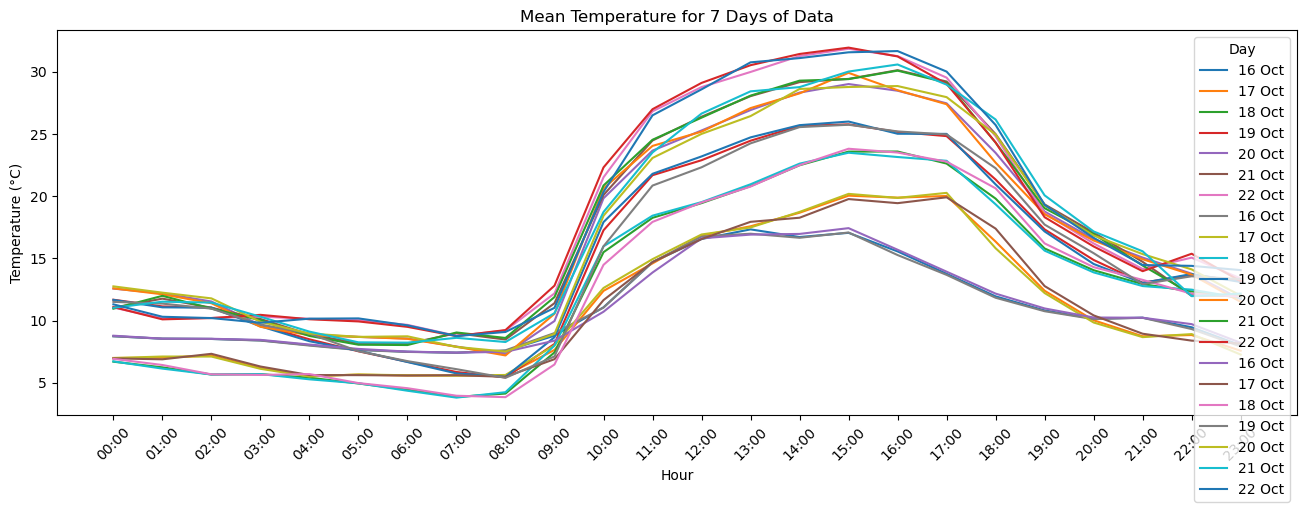

In [10]:
## Mean temperature for each time interval on one plot

fig, axes = plt.subplots(1,1,figsize = (16,5))

idx_days = range(7) 

calibration_4_shield_on_intervals = pd.DataFrame()

for idx_day in idx_days:
    start_date = datetime.strptime('2024-10-{} 23:30:00'.format(idx_day+15), '%Y-%m-%d %H:%M:%S')
    end_date = datetime.strptime('2024-10-{} 23:30:00'.format(idx_day+16), '%Y-%m-%d %H:%M:%S')
    
    calibration_dataframe = calibration_4_shield_on_data[(calibration_4_shield_on_data.Date_Time_Format > start_date) & (
                                calibration_4_shield_on_data.Date_Time_Format < end_date)]
    
    hourly_means = calibration_dataframe.groupby(['Sensor_ID','Custom_Hour']).mean(numeric_only = True).reset_index()

    means = hourly_means.groupby('Custom_Hour').mean(numeric_only = True).reset_index(
                            )[['Custom_Hour', 'Temperature']].rename(columns ={ 'Temperature':'Temperature_Mean'})

    stds = hourly_means.groupby('Custom_Hour').std(numeric_only = True).reset_index(
                            )[['Custom_Hour', 'Temperature']].rename(columns ={ 'Temperature':'Temperature_Std'})

    mins = hourly_means.groupby('Custom_Hour').min(numeric_only = True).reset_index(
                            )[['Custom_Hour', 'Temperature']].rename(columns ={ 'Temperature':'Temperature_Min'})

    maxs = hourly_means.groupby('Custom_Hour').max(numeric_only = True).reset_index(
                            )[['Custom_Hour', 'Temperature']].rename(columns ={ 'Temperature':'Temperature_Max'})

    axes.plot(means.Custom_Hour, means.Temperature_Mean, label = '{} Oct'.format(idx_day+16))
    
    temp_df = pd.merge(means, stds, on = 'Custom_Hour', how = 'inner')
    temp_df['Day'] = '{}_Oct'.format(idx_day+16)
    calibration_4_shield_on_intervals = pd.concat([calibration_4_shield_on_intervals,temp_df])
#calibration_4_shield_on_data

calibration_4_shield_on_intervals2 = pd.DataFrame()

for idx_day in idx_days:
    start_date = datetime.strptime('2024-10-{} 23:30:00'.format(idx_day+15), '%Y-%m-%d %H:%M:%S')
    end_date = datetime.strptime('2024-10-{} 23:30:00'.format(idx_day+16), '%Y-%m-%d %H:%M:%S')
    
    calibration_dataframe2 = calibration_4_shield_on_data_20_min[(calibration_4_shield_on_data_20_min.Date_Time_Format > start_date) & (
                                calibration_4_shield_on_data_20_min.Date_Time_Format < end_date)]
    
    hourly_means = calibration_dataframe2.groupby(['Sensor_ID','Custom_Hour']).mean(numeric_only = True).reset_index()

    means = hourly_means.groupby('Custom_Hour').mean(numeric_only = True).reset_index(
                            )[['Custom_Hour', 'Temperature']].rename(columns ={ 'Temperature':'Temperature_Mean'})

    stds = hourly_means.groupby('Custom_Hour').std(numeric_only = True).reset_index(
                            )[['Custom_Hour', 'Temperature']].rename(columns ={ 'Temperature':'Temperature_Std'})

    mins = hourly_means.groupby('Custom_Hour').min(numeric_only = True).reset_index(
                            )[['Custom_Hour', 'Temperature']].rename(columns ={ 'Temperature':'Temperature_Min'})

    maxs = hourly_means.groupby('Custom_Hour').max(numeric_only = True).reset_index(
                            )[['Custom_Hour', 'Temperature']].rename(columns ={ 'Temperature':'Temperature_Max'})

    
    axes.plot(means.Custom_Hour, means.Temperature_Mean, label = '{} Oct'.format(idx_day+16))
    
    temp_df = pd.merge(means, stds, on = 'Custom_Hour', how = 'inner')
    temp_df['Day'] = '{}_Oct'.format(idx_day+16)
    calibration_4_shield_on_intervals2 = pd.concat([calibration_4_shield_on_intervals2,temp_df])

calibration_4_shield_on_intervals3 = pd.DataFrame()

for idx_day in idx_days:
    start_date = datetime.strptime('2024-10-{} 23:30:00'.format(idx_day+15), '%Y-%m-%d %H:%M:%S')
    end_date = datetime.strptime('2024-10-{} 23:30:00'.format(idx_day+16), '%Y-%m-%d %H:%M:%S')
    
    calibration_dataframe3 = calibration_4_shield_on_data_30_min[(calibration_4_shield_on_data_30_min.Date_Time_Format > start_date) & (
                                calibration_4_shield_on_data_30_min.Date_Time_Format < end_date)]
    
    hourly_means = calibration_dataframe3.groupby(['Sensor_ID','Custom_Hour']).mean(numeric_only = True).reset_index()

    means = hourly_means.groupby('Custom_Hour').mean(numeric_only = True).reset_index(
                            )[['Custom_Hour', 'Temperature']].rename(columns ={ 'Temperature':'Temperature_Mean'})

    stds = hourly_means.groupby('Custom_Hour').std(numeric_only = True).reset_index(
                            )[['Custom_Hour', 'Temperature']].rename(columns ={ 'Temperature':'Temperature_Std'})

    mins = hourly_means.groupby('Custom_Hour').min(numeric_only = True).reset_index(
                            )[['Custom_Hour', 'Temperature']].rename(columns ={ 'Temperature':'Temperature_Min'})

    maxs = hourly_means.groupby('Custom_Hour').max(numeric_only = True).reset_index(
                            )[['Custom_Hour', 'Temperature']].rename(columns ={ 'Temperature':'Temperature_Max'})

    axes.plot(means.Custom_Hour, means.Temperature_Mean, label = '{} Oct'.format(idx_day+16))
    
    temp_df = pd.merge(means, stds, on = 'Custom_Hour', how = 'inner')
    temp_df['Day'] = '{}_Oct'.format(idx_day+16)
    calibration_4_shield_on_intervals3 = pd.concat([calibration_4_shield_on_intervals3,temp_df])

axes.set(title = 'Mean Temperature for 7 Days of Data', xlabel= 'Hour', ylabel='Temperature (\u00B0C)')
axes.legend(title = 'Day')
axes.tick_params(axis='x', labelrotation=45)

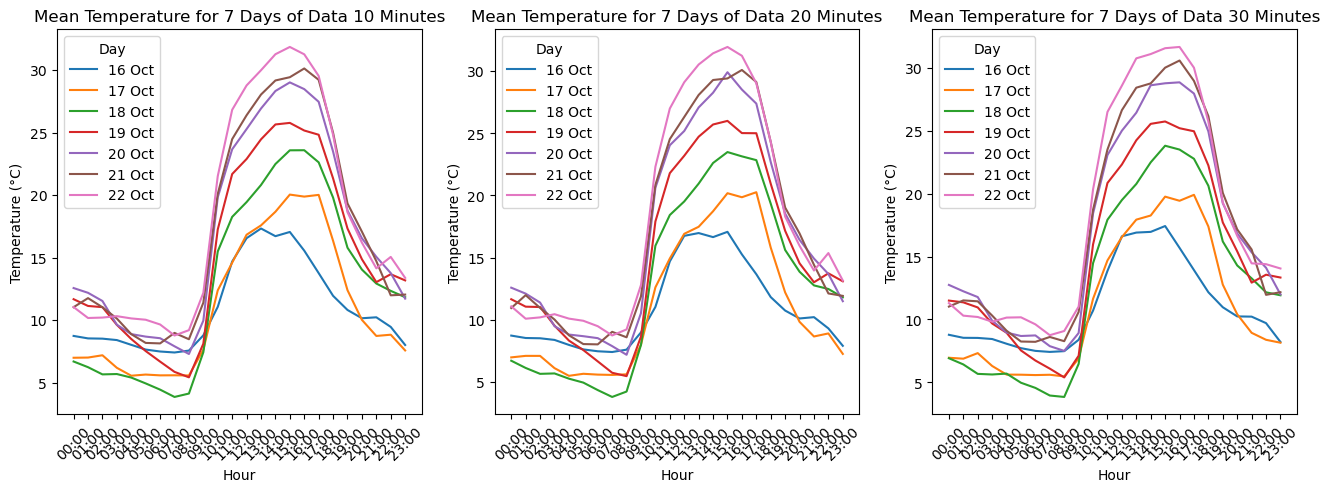

In [11]:
## Mean temperature for each time interval on separate plots

fig, axes = plt.subplots(1,3,figsize = (16,5))

idx_days = range(7) 

calibration_4_shield_on_intervals = pd.DataFrame()

for idx_day in idx_days:
    start_date = datetime.strptime('2024-10-{} 23:30:00'.format(idx_day+15), '%Y-%m-%d %H:%M:%S')
    end_date = datetime.strptime('2024-10-{} 23:30:00'.format(idx_day+16), '%Y-%m-%d %H:%M:%S')
    
    calibration_dataframe = calibration_4_shield_on_data[(calibration_4_shield_on_data.Date_Time_Format > start_date) & (
                                calibration_4_shield_on_data.Date_Time_Format < end_date)]
    
    hourly_means = calibration_dataframe.groupby(['Sensor_ID','Custom_Hour']).mean(numeric_only = True).reset_index()

    means = hourly_means.groupby('Custom_Hour').mean(numeric_only = True).reset_index(
                            )[['Custom_Hour', 'Temperature']].rename(columns ={ 'Temperature':'Temperature_Mean'})

    stds = hourly_means.groupby('Custom_Hour').std(numeric_only = True).reset_index(
                            )[['Custom_Hour', 'Temperature']].rename(columns ={ 'Temperature':'Temperature_Std'})

    mins = hourly_means.groupby('Custom_Hour').min(numeric_only = True).reset_index(
                            )[['Custom_Hour', 'Temperature']].rename(columns ={ 'Temperature':'Temperature_Min'})

    maxs = hourly_means.groupby('Custom_Hour').max(numeric_only = True).reset_index(
                            )[['Custom_Hour', 'Temperature']].rename(columns ={ 'Temperature':'Temperature_Max'})

    axes[0].plot(means.Custom_Hour, means.Temperature_Mean, label = '{} Oct'.format(idx_day+16))
    
    temp_df = pd.merge(means, stds, on = 'Custom_Hour', how = 'inner')
    temp_df['Day'] = '{}_Oct'.format(idx_day+16)
    calibration_4_shield_on_intervals = pd.concat([calibration_4_shield_on_intervals,temp_df])
#calibration_4_shield_on_data

calibration_4_shield_on_intervals2 = pd.DataFrame()

for idx_day in idx_days:
    start_date = datetime.strptime('2024-10-{} 23:30:00'.format(idx_day+15), '%Y-%m-%d %H:%M:%S')
    end_date = datetime.strptime('2024-10-{} 23:30:00'.format(idx_day+16), '%Y-%m-%d %H:%M:%S')
    
    calibration_dataframe2 = calibration_4_shield_on_data_20_min[(calibration_4_shield_on_data_20_min.Date_Time_Format > start_date) & (
                                calibration_4_shield_on_data_20_min.Date_Time_Format < end_date)]
    
    hourly_means = calibration_dataframe2.groupby(['Sensor_ID','Custom_Hour']).mean(numeric_only = True).reset_index()

    means = hourly_means.groupby('Custom_Hour').mean(numeric_only = True).reset_index(
                            )[['Custom_Hour', 'Temperature']].rename(columns ={ 'Temperature':'Temperature_Mean'})

    stds = hourly_means.groupby('Custom_Hour').std(numeric_only = True).reset_index(
                            )[['Custom_Hour', 'Temperature']].rename(columns ={ 'Temperature':'Temperature_Std'})

    mins = hourly_means.groupby('Custom_Hour').min(numeric_only = True).reset_index(
                            )[['Custom_Hour', 'Temperature']].rename(columns ={ 'Temperature':'Temperature_Min'})

    maxs = hourly_means.groupby('Custom_Hour').max(numeric_only = True).reset_index(
                            )[['Custom_Hour', 'Temperature']].rename(columns ={ 'Temperature':'Temperature_Max'})

    
    axes[1].plot(means.Custom_Hour, means.Temperature_Mean, label = '{} Oct'.format(idx_day+16))
    
    temp_df = pd.merge(means, stds, on = 'Custom_Hour', how = 'inner')
    temp_df['Day'] = '{}_Oct'.format(idx_day+16)
    calibration_4_shield_on_intervals2 = pd.concat([calibration_4_shield_on_intervals2,temp_df])

calibration_4_shield_on_intervals3 = pd.DataFrame()

for idx_day in idx_days:
    start_date = datetime.strptime('2024-10-{} 23:30:00'.format(idx_day+15), '%Y-%m-%d %H:%M:%S')
    end_date = datetime.strptime('2024-10-{} 23:30:00'.format(idx_day+16), '%Y-%m-%d %H:%M:%S')
    
    calibration_dataframe3 = calibration_4_shield_on_data_30_min[(calibration_4_shield_on_data_30_min.Date_Time_Format > start_date) & (
                                calibration_4_shield_on_data_30_min.Date_Time_Format < end_date)]
    
    hourly_means = calibration_dataframe3.groupby(['Sensor_ID','Custom_Hour']).mean(numeric_only = True).reset_index()

    means = hourly_means.groupby('Custom_Hour').mean(numeric_only = True).reset_index(
                            )[['Custom_Hour', 'Temperature']].rename(columns ={ 'Temperature':'Temperature_Mean'})

    stds = hourly_means.groupby('Custom_Hour').std(numeric_only = True).reset_index(
                            )[['Custom_Hour', 'Temperature']].rename(columns ={ 'Temperature':'Temperature_Std'})

    mins = hourly_means.groupby('Custom_Hour').min(numeric_only = True).reset_index(
                            )[['Custom_Hour', 'Temperature']].rename(columns ={ 'Temperature':'Temperature_Min'})

    maxs = hourly_means.groupby('Custom_Hour').max(numeric_only = True).reset_index(
                            )[['Custom_Hour', 'Temperature']].rename(columns ={ 'Temperature':'Temperature_Max'})

    axes[2].plot(means.Custom_Hour, means.Temperature_Mean, label = '{} Oct'.format(idx_day+16))
    
    temp_df = pd.merge(means, stds, on = 'Custom_Hour', how = 'inner')
    temp_df['Day'] = '{}_Oct'.format(idx_day+16)
    calibration_4_shield_on_intervals3 = pd.concat([calibration_4_shield_on_intervals3,temp_df])

axes[0].set(title = 'Mean Temperature for 7 Days of Data 10 Minutes', xlabel= 'Hour', ylabel='Temperature (\u00B0C)')
axes[0].legend(title = 'Day')
axes[0].tick_params(axis='x', labelrotation=45)
axes[1].set(title = 'Mean Temperature for 7 Days of Data 20 Minutes', xlabel= 'Hour', ylabel='Temperature (\u00B0C)')
axes[1].legend(title = 'Day')
axes[1].tick_params(axis='x', labelrotation=45)
axes[2].set(title = 'Mean Temperature for 7 Days of Data 30 Minutes', xlabel= 'Hour', ylabel='Temperature (\u00B0C)')
axes[2].legend(title = 'Day')
axes[2].tick_params(axis='x', labelrotation=45)

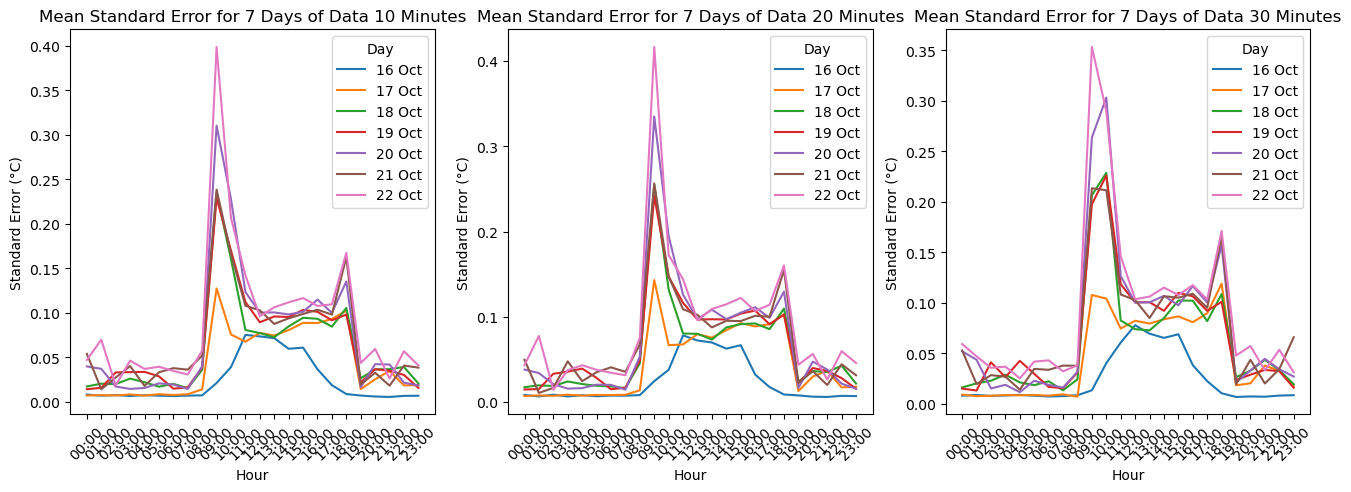

In [12]:
## Mean standard error for each time interval on separate plots

fig, axes = plt.subplots(1,3,figsize = (16,5))

idx_days = range(7) 

calibration_4_shield_on_intervals = pd.DataFrame()

for idx_day in idx_days:
    start_date = datetime.strptime('2024-10-{} 23:30:00'.format(idx_day+15), '%Y-%m-%d %H:%M:%S')
    end_date = datetime.strptime('2024-10-{} 23:30:00'.format(idx_day+16), '%Y-%m-%d %H:%M:%S')
    
    calibration_dataframe = calibration_4_shield_on_data[(calibration_4_shield_on_data.Date_Time_Format > start_date) & (
                                calibration_4_shield_on_data.Date_Time_Format < end_date)]
    
    hourly_means = calibration_dataframe.groupby(['Sensor_ID','Custom_Hour']).mean(numeric_only = True).reset_index()

    means = hourly_means.groupby('Custom_Hour').mean(numeric_only = True).reset_index(
                            )[['Custom_Hour', 'Temperature']].rename(columns ={ 'Temperature':'Temperature_Mean'})

    stds = hourly_means.groupby('Custom_Hour').std(numeric_only = True).reset_index(
                            )[['Custom_Hour', 'Temperature']].rename(columns ={ 'Temperature':'Temperature_Std'})

    mins = hourly_means.groupby('Custom_Hour').min(numeric_only = True).reset_index(
                            )[['Custom_Hour', 'Temperature']].rename(columns ={ 'Temperature':'Temperature_Min'})

    maxs = hourly_means.groupby('Custom_Hour').max(numeric_only = True).reset_index(
                            )[['Custom_Hour', 'Temperature']].rename(columns ={ 'Temperature':'Temperature_Max'})

    axes[0].plot(stds.Custom_Hour, stds.Temperature_Std/ np.sqrt(41), label = '{} Oct'.format(idx_day+16))
    
    temp_df = pd.merge(means, stds, on = 'Custom_Hour', how = 'inner')
    temp_df['Day'] = '{}_Oct'.format(idx_day+16)
    calibration_4_shield_on_intervals = pd.concat([calibration_4_shield_on_intervals,temp_df])
#calibration_4_shield_on_data

calibration_4_shield_on_intervals2 = pd.DataFrame()

for idx_day in idx_days:
    start_date = datetime.strptime('2024-10-{} 23:30:00'.format(idx_day+15), '%Y-%m-%d %H:%M:%S')
    end_date = datetime.strptime('2024-10-{} 23:30:00'.format(idx_day+16), '%Y-%m-%d %H:%M:%S')
    
    calibration_dataframe2 = calibration_4_shield_on_data_20_min[(calibration_4_shield_on_data_20_min.Date_Time_Format > start_date) & (
                                calibration_4_shield_on_data_20_min.Date_Time_Format < end_date)]
    
    hourly_means = calibration_dataframe2.groupby(['Sensor_ID','Custom_Hour']).mean(numeric_only = True).reset_index()

    means = hourly_means.groupby('Custom_Hour').mean(numeric_only = True).reset_index(
                            )[['Custom_Hour', 'Temperature']].rename(columns ={ 'Temperature':'Temperature_Mean'})

    stds = hourly_means.groupby('Custom_Hour').std(numeric_only = True).reset_index(
                            )[['Custom_Hour', 'Temperature']].rename(columns ={ 'Temperature':'Temperature_Std'})

    mins = hourly_means.groupby('Custom_Hour').min(numeric_only = True).reset_index(
                            )[['Custom_Hour', 'Temperature']].rename(columns ={ 'Temperature':'Temperature_Min'})

    maxs = hourly_means.groupby('Custom_Hour').max(numeric_only = True).reset_index(
                            )[['Custom_Hour', 'Temperature']].rename(columns ={ 'Temperature':'Temperature_Max'})

    
    axes[1].plot(stds.Custom_Hour, stds.Temperature_Std/ np.sqrt(41), label = '{} Oct'.format(idx_day+16))
    
    temp_df = pd.merge(means, stds, on = 'Custom_Hour', how = 'inner')
    temp_df['Day'] = '{}_Oct'.format(idx_day+16)
    calibration_4_shield_on_intervals2 = pd.concat([calibration_4_shield_on_intervals2,temp_df])

calibration_4_shield_on_intervals3 = pd.DataFrame()

for idx_day in idx_days:
    start_date = datetime.strptime('2024-10-{} 23:30:00'.format(idx_day+15), '%Y-%m-%d %H:%M:%S')
    end_date = datetime.strptime('2024-10-{} 23:30:00'.format(idx_day+16), '%Y-%m-%d %H:%M:%S')
    
    calibration_dataframe3 = calibration_4_shield_on_data_30_min[(calibration_4_shield_on_data_30_min.Date_Time_Format > start_date) & (
                                calibration_4_shield_on_data_30_min.Date_Time_Format < end_date)]
    
    hourly_means = calibration_dataframe3.groupby(['Sensor_ID','Custom_Hour']).mean(numeric_only = True).reset_index()

    means = hourly_means.groupby('Custom_Hour').mean(numeric_only = True).reset_index(
                            )[['Custom_Hour', 'Temperature']].rename(columns ={ 'Temperature':'Temperature_Mean'})

    stds = hourly_means.groupby('Custom_Hour').std(numeric_only = True).reset_index(
                            )[['Custom_Hour', 'Temperature']].rename(columns ={ 'Temperature':'Temperature_Std'})

    mins = hourly_means.groupby('Custom_Hour').min(numeric_only = True).reset_index(
                            )[['Custom_Hour', 'Temperature']].rename(columns ={ 'Temperature':'Temperature_Min'})

    maxs = hourly_means.groupby('Custom_Hour').max(numeric_only = True).reset_index(
                            )[['Custom_Hour', 'Temperature']].rename(columns ={ 'Temperature':'Temperature_Max'})

    axes[2].plot(stds.Custom_Hour, stds.Temperature_Std/ np.sqrt(41), label = '{} Oct'.format(idx_day+16))
        
    temp_df = pd.merge(means, stds, on = 'Custom_Hour', how = 'inner')
    temp_df['Day'] = '{}_Oct'.format(idx_day+16)
    calibration_4_shield_on_intervals3 = pd.concat([calibration_4_shield_on_intervals3,temp_df])

axes[0].set(title = 'Mean Standard Error for 7 Days of Data 10 Minutes', xlabel= 'Hour', ylabel='Standard Error (\u00B0C)')
axes[0].legend(title = 'Day')
axes[0].tick_params(axis='x', labelrotation=45)
axes[1].set(title = 'Mean Standard Error for 7 Days of Data 20 Minutes', xlabel= 'Hour', ylabel='Standard Error (\u00B0C)')
axes[1].legend(title = 'Day')
axes[1].tick_params(axis='x', labelrotation=45)
axes[2].set(title = 'Mean Standard Error for 7 Days of Data 30 Minutes', xlabel= 'Hour', ylabel='Standard Error (\u00B0C)')
axes[2].legend(title = 'Day')
axes[2].tick_params(axis='x', labelrotation=45)

[Text(0.5, 1.0, 'Pre-Calibration (4-6th October)'),
 Text(0.5, 0, 'Hour'),
 Text(0, 0.5, 'Temperature (°C)')]

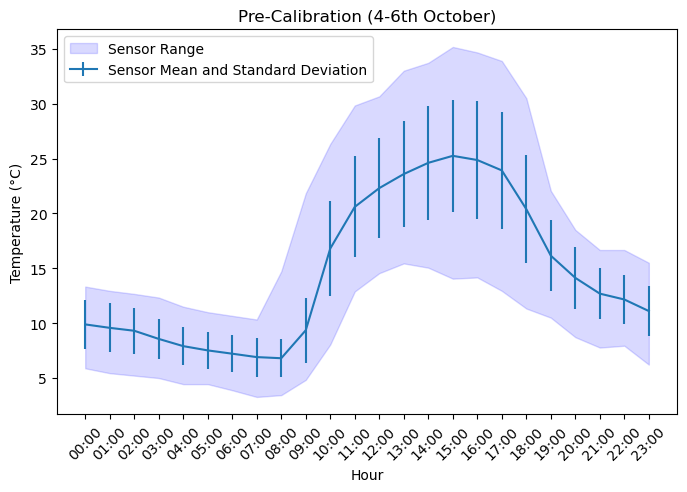

In [13]:
# plot with standard error bars 
fig, axes = plt.subplots(1,1,figsize = (8,5))

means = calibration_4_shield_on_data.groupby('Custom_Hour').mean(numeric_only = True).reset_index()[['Custom_Hour','Temperature']]
std_err = calibration_4_shield_on_data.groupby('Custom_Hour').std(numeric_only = True).reset_index()[['Custom_Hour','Temperature']]
#std_err['Temperature'] = std_err['Temperature'] /np.sqrt(41)

max_temp = calibration_4_shield_on_data.groupby('Custom_Hour').max(numeric_only = True).reset_index()[['Custom_Hour','Temperature']]
min_temp = calibration_4_shield_on_data.groupby('Custom_Hour').min(numeric_only = True).reset_index()[['Custom_Hour','Temperature']]

axes.errorbar(means.Custom_Hour, means.Temperature, yerr=std_err.Temperature, label = 'Sensor Mean and Standard Deviation')
axes.fill_between(max_temp.Custom_Hour, min_temp.Temperature,  max_temp.Temperature, color='b', alpha=.15, label = 'Sensor Range')

plt.legend()
plt.xticks(rotation=45)
axes.set(title = 'Pre-Calibration (4-6th October)', xlabel= 'Hour', ylabel='Temperature (\u00B0C)')

[Text(0.5, 1.0, 'Pre-Calibration (4-6th October)'),
 Text(0.5, 0, 'Hour'),
 Text(0, 0.5, 'Temperature (°C)')]

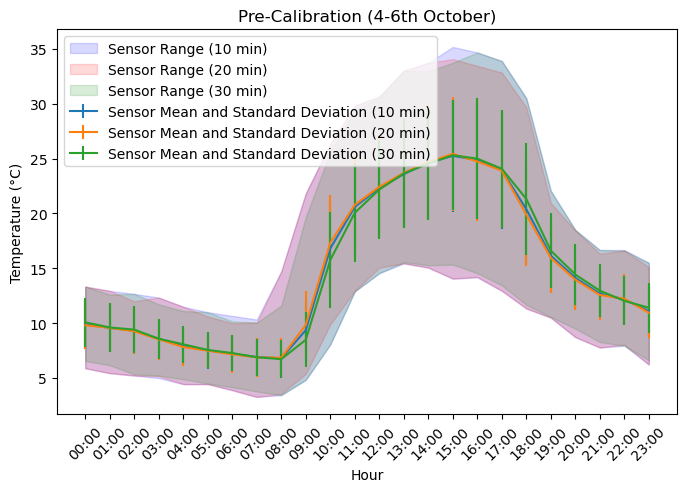

In [14]:
# a single plot with standard error bars for each time interval
fig, axes = plt.subplots(1,1,figsize = (8,5))

means = calibration_4_shield_on_data.groupby('Custom_Hour').mean(numeric_only = True).reset_index()[['Custom_Hour','Temperature']]
std_err = calibration_4_shield_on_data.groupby('Custom_Hour').std(numeric_only = True).reset_index()[['Custom_Hour','Temperature']]
#std_err['Temperature'] = std_err['Temperature'] /np.sqrt(41)

max_temp = calibration_4_shield_on_data.groupby('Custom_Hour').max(numeric_only = True).reset_index()[['Custom_Hour','Temperature']]
min_temp = calibration_4_shield_on_data.groupby('Custom_Hour').min(numeric_only = True).reset_index()[['Custom_Hour','Temperature']]

axes.errorbar(means.Custom_Hour, means.Temperature, yerr=std_err.Temperature, label = 'Sensor Mean and Standard Deviation (10 min)')
axes.fill_between(max_temp.Custom_Hour, min_temp.Temperature,  max_temp.Temperature, color='b', alpha=.15, label = 'Sensor Range (10 min)')

means2 = calibration_4_shield_on_data_20_min.groupby('Custom_Hour').mean(numeric_only = True).reset_index()[['Custom_Hour','Temperature']]
std_err2 = calibration_4_shield_on_data_20_min.groupby('Custom_Hour').std(numeric_only = True).reset_index()[['Custom_Hour','Temperature']]
#std_err['Temperature'] = std_err['Temperature'] /np.sqrt(41)

max_temp2 = calibration_4_shield_on_data_20_min.groupby('Custom_Hour').max(numeric_only = True).reset_index()[['Custom_Hour','Temperature']]
min_temp2 = calibration_4_shield_on_data_20_min.groupby('Custom_Hour').min(numeric_only = True).reset_index()[['Custom_Hour','Temperature']]

axes.errorbar(means2.Custom_Hour, means2.Temperature, yerr=std_err2.Temperature, label = 'Sensor Mean and Standard Deviation (20 min)')
axes.fill_between(max_temp2.Custom_Hour, min_temp2.Temperature,  max_temp2.Temperature, color='r', alpha=.15, label = 'Sensor Range (20 min)')

means3 = calibration_4_shield_on_data_30_min.groupby('Custom_Hour').mean(numeric_only = True).reset_index()[['Custom_Hour','Temperature']]
std_err3 = calibration_4_shield_on_data_30_min.groupby('Custom_Hour').std(numeric_only = True).reset_index()[['Custom_Hour','Temperature']]
#std_err['Temperature'] = std_err['Temperature'] /np.sqrt(41)

max_temp3 = calibration_4_shield_on_data_30_min.groupby('Custom_Hour').max(numeric_only = True).reset_index()[['Custom_Hour','Temperature']]
min_temp3 = calibration_4_shield_on_data_30_min.groupby('Custom_Hour').min(numeric_only = True).reset_index()[['Custom_Hour','Temperature']]

axes.errorbar(means3.Custom_Hour, means3.Temperature, yerr=std_err3.Temperature, label = 'Sensor Mean and Standard Deviation (30 min)')
axes.fill_between(max_temp3.Custom_Hour, min_temp3.Temperature,  max_temp3.Temperature, color='g', alpha=.15, label = 'Sensor Range (30 min)')

plt.legend()
plt.xticks(rotation=45)
axes.set(title = 'Pre-Calibration (4-6th October)', xlabel= 'Hour', ylabel='Temperature (\u00B0C)')

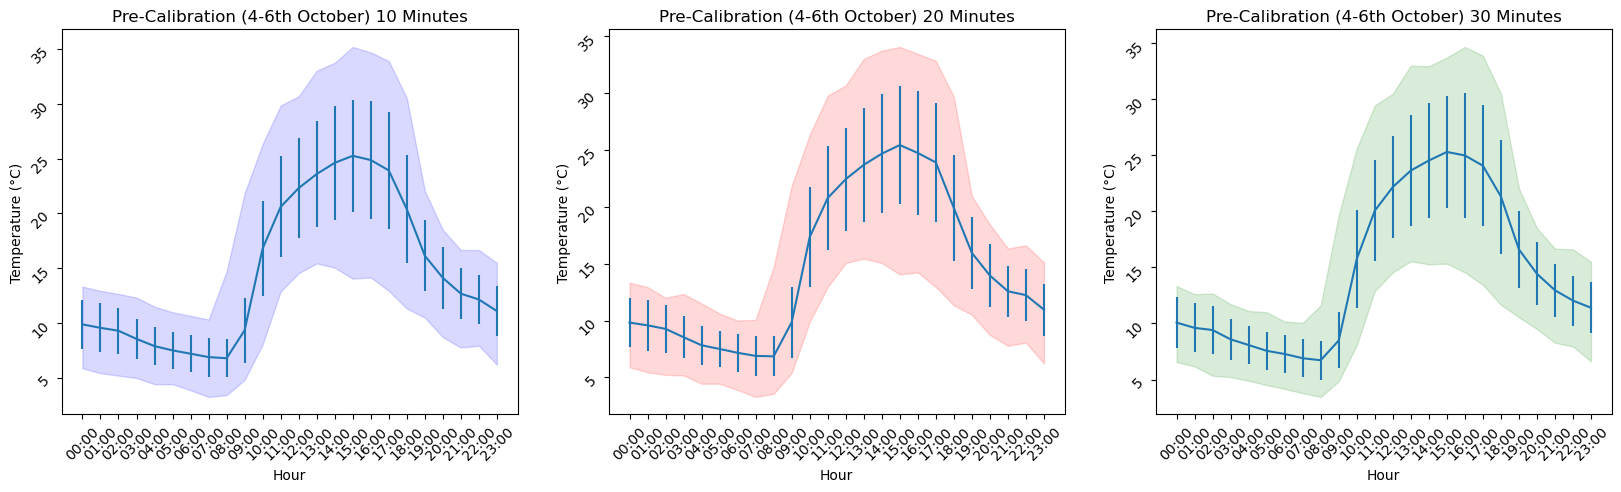

In [15]:
# a plot with standard error bars for each time interval

fig, axes = plt.subplots(1,3,figsize = (20,5))

means = calibration_4_shield_on_data.groupby('Custom_Hour').mean(numeric_only = True).reset_index()[['Custom_Hour','Temperature']]
std_err = calibration_4_shield_on_data.groupby('Custom_Hour').std(numeric_only = True).reset_index()[['Custom_Hour','Temperature']]
#std_err['Temperature'] = std_err['Temperature'] /np.sqrt(41)

max_temp = calibration_4_shield_on_data.groupby('Custom_Hour').max(numeric_only = True).reset_index()[['Custom_Hour','Temperature']]
min_temp = calibration_4_shield_on_data.groupby('Custom_Hour').min(numeric_only = True).reset_index()[['Custom_Hour','Temperature']]

axes[0].errorbar(means.Custom_Hour, means.Temperature, yerr=std_err.Temperature, label = 'Sensor Mean and Standard Deviation (10 min)')
axes[0].fill_between(max_temp.Custom_Hour, min_temp.Temperature,  max_temp.Temperature, color='b', alpha=.15, label = 'Sensor Range (10 min)')
axes[0].set(title = 'Pre-Calibration (4-6th October) 10 Minutes', xlabel= 'Hour', ylabel='Temperature (\u00B0C)')
axes[0].tick_params(labelrotation=45)

means2 = calibration_4_shield_on_data_20_min.groupby('Custom_Hour').mean(numeric_only = True).reset_index()[['Custom_Hour','Temperature']]
std_err2 = calibration_4_shield_on_data_20_min.groupby('Custom_Hour').std(numeric_only = True).reset_index()[['Custom_Hour','Temperature']]
#std_err['Temperature'] = std_err['Temperature'] /np.sqrt(41)

max_temp2 = calibration_4_shield_on_data_20_min.groupby('Custom_Hour').max(numeric_only = True).reset_index()[['Custom_Hour','Temperature']]
min_temp2 = calibration_4_shield_on_data_20_min.groupby('Custom_Hour').min(numeric_only = True).reset_index()[['Custom_Hour','Temperature']]

axes[1].errorbar(means2.Custom_Hour, means2.Temperature, yerr=std_err2.Temperature, label = 'Sensor Mean and Standard Deviation (20 min)')
axes[1].fill_between(max_temp2.Custom_Hour, min_temp2.Temperature,  max_temp2.Temperature, color='r', alpha=.15, label = 'Sensor Range (20 min)')
axes[1].set(title = 'Pre-Calibration (4-6th October) 20 Minutes', xlabel= 'Hour', ylabel='Temperature (\u00B0C)')
axes[1].tick_params(labelrotation=45)

means3 = calibration_4_shield_on_data_30_min.groupby('Custom_Hour').mean(numeric_only = True).reset_index()[['Custom_Hour','Temperature']]
std_err3 = calibration_4_shield_on_data_30_min.groupby('Custom_Hour').std(numeric_only = True).reset_index()[['Custom_Hour','Temperature']]
#std_err['Temperature'] = std_err['Temperature'] /np.sqrt(41)

max_temp3 = calibration_4_shield_on_data_30_min.groupby('Custom_Hour').max(numeric_only = True).reset_index()[['Custom_Hour','Temperature']]
min_temp3 = calibration_4_shield_on_data_30_min.groupby('Custom_Hour').min(numeric_only = True).reset_index()[['Custom_Hour','Temperature']]

axes[2].errorbar(means3.Custom_Hour, means3.Temperature, yerr=std_err3.Temperature, label = 'Sensor Mean and Standard Deviation (30 min)')
axes[2].fill_between(max_temp3.Custom_Hour, min_temp3.Temperature,  max_temp3.Temperature, color='g', alpha=.15, label = 'Sensor Range (30 min)')
axes[2].set(title = 'Pre-Calibration (4-6th October) 30 Minutes', xlabel= 'Hour', ylabel='Temperature (\u00B0C)')
axes[2].tick_params(labelrotation=45)

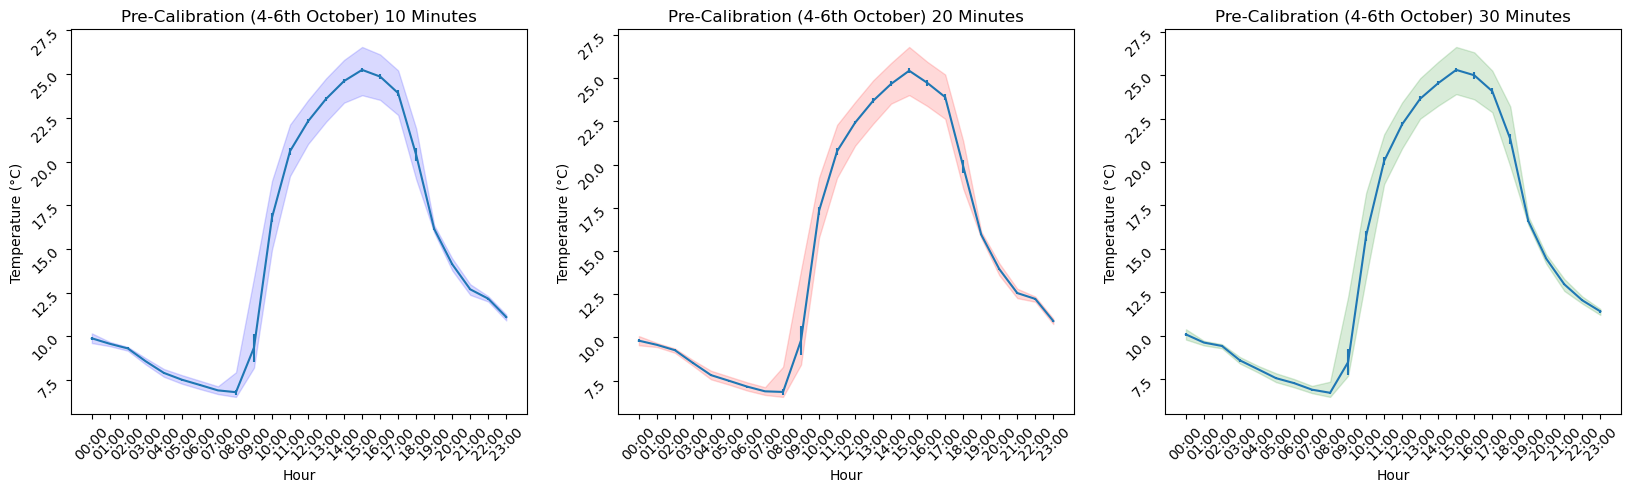

In [16]:
fig, axes = plt.subplots(1,3,figsize = (20,5))

calibration_4_shield_on_data_means = calibration_4_shield_on_data.groupby(['Sensor_ID', 'Custom_Hour']).mean(numeric_only=True).reset_index()
calibration_4_shield_on_data_std_error = calibration_4_shield_on_data.groupby(['Sensor_ID', 'Custom_Hour']).std(numeric_only=True).reset_index()

means = calibration_4_shield_on_data_means.groupby('Custom_Hour').mean(numeric_only = True).reset_index()[['Custom_Hour','Temperature']]
std_err = calibration_4_shield_on_data_std_error.groupby('Custom_Hour').std(numeric_only = True).reset_index()[['Custom_Hour','Temperature']]
#std_err['Temperature'] = std_err['Temperature'] /np.sqrt(41)

max_temp = calibration_4_shield_on_data_means.groupby('Custom_Hour').max(numeric_only = True).reset_index()[['Custom_Hour','Temperature']]
min_temp = calibration_4_shield_on_data_means.groupby('Custom_Hour').min(numeric_only = True).reset_index()[['Custom_Hour','Temperature']]

axes[0].errorbar(means.Custom_Hour, means.Temperature, yerr=std_err.Temperature, label = 'Sensor Mean and Standard Deviation (10 min)')
axes[0].fill_between(max_temp.Custom_Hour, min_temp.Temperature,  max_temp.Temperature, color='b', alpha=.15, label = 'Sensor Range (10 min)')
axes[0].set(title = 'Pre-Calibration (4-6th October) 10 Minutes', xlabel= 'Hour', ylabel='Temperature (\u00B0C)')
axes[0].tick_params(labelrotation=45)

calibration_4_shield_on_data_means2 = calibration_4_shield_on_data_20_min.groupby(['Sensor_ID', 'Custom_Hour']).mean(numeric_only=True).reset_index()
calibration_4_shield_on_data_std_error2 = calibration_4_shield_on_data_20_min.groupby(['Sensor_ID', 'Custom_Hour']).std(numeric_only=True).reset_index()

means2 = calibration_4_shield_on_data_means2.groupby('Custom_Hour').mean(numeric_only = True).reset_index()[['Custom_Hour','Temperature']]
std_err2 = calibration_4_shield_on_data_std_error2.groupby('Custom_Hour').std(numeric_only = True).reset_index()[['Custom_Hour','Temperature']]
#std_err['Temperature'] = std_err['Temperature'] /np.sqrt(41)

max_temp2 = calibration_4_shield_on_data_means2.groupby('Custom_Hour').max(numeric_only = True).reset_index()[['Custom_Hour','Temperature']]
min_temp2 = calibration_4_shield_on_data_means2.groupby('Custom_Hour').min(numeric_only = True).reset_index()[['Custom_Hour','Temperature']]

axes[1].errorbar(means2.Custom_Hour, means2.Temperature, yerr=std_err2.Temperature, label = 'Sensor Mean and Standard Deviation (20 min)')
axes[1].fill_between(max_temp2.Custom_Hour, min_temp2.Temperature,  max_temp2.Temperature, color='r', alpha=.15, label = 'Sensor Range (20 min)')
axes[1].set(title = 'Pre-Calibration (4-6th October) 20 Minutes', xlabel= 'Hour', ylabel='Temperature (\u00B0C)')
axes[1].tick_params(labelrotation=45)

calibration_4_shield_on_data_means3 = calibration_4_shield_on_data_30_min.groupby(['Sensor_ID', 'Custom_Hour']).mean(numeric_only=True).reset_index()
calibration_4_shield_on_data_std_error3 = calibration_4_shield_on_data_30_min.groupby(['Sensor_ID', 'Custom_Hour']).std(numeric_only=True).reset_index()

means3 = calibration_4_shield_on_data_means3.groupby('Custom_Hour').mean(numeric_only = True).reset_index()[['Custom_Hour','Temperature']]
std_err3 = calibration_4_shield_on_data_std_error3.groupby('Custom_Hour').std(numeric_only = True).reset_index()[['Custom_Hour','Temperature']]
#std_err['Temperature'] = std_err['Temperature'] /np.sqrt(41)

max_temp3 = calibration_4_shield_on_data_means3.groupby('Custom_Hour').max(numeric_only = True).reset_index()[['Custom_Hour','Temperature']]
min_temp3 = calibration_4_shield_on_data_means3.groupby('Custom_Hour').min(numeric_only = True).reset_index()[['Custom_Hour','Temperature']]

axes[2].errorbar(means3.Custom_Hour, means3.Temperature, yerr=std_err3.Temperature, label = 'Sensor Mean and Standard Deviation (30 min)')
axes[2].fill_between(max_temp3.Custom_Hour, min_temp3.Temperature,  max_temp3.Temperature, color='g', alpha=.15, label = 'Sensor Range (30 min)')
axes[2].set(title = 'Pre-Calibration (4-6th October) 30 Minutes', xlabel= 'Hour', ylabel='Temperature (\u00B0C)')
axes[2].tick_params(labelrotation=45)

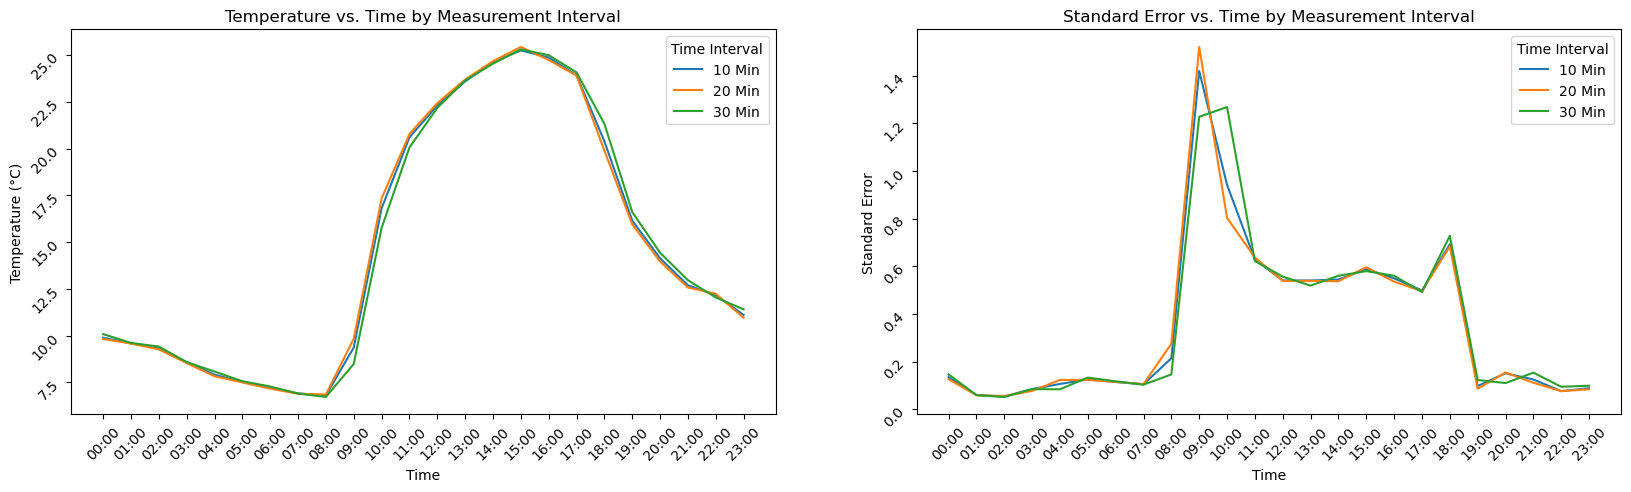

In [17]:
fig, axes = plt.subplots(1,2,figsize = (20,5))

hourly_means = calibration_4_shield_on_data.groupby(['Sensor_ID','Custom_Hour']).mean(numeric_only = True).reset_index()

means = hourly_means.groupby('Custom_Hour').mean(numeric_only = True).reset_index(
                            )[['Custom_Hour', 'Temperature']].rename(columns ={ 'Temperature':'Temperature_Mean'})

stds = hourly_means.groupby('Custom_Hour').std(numeric_only = True).reset_index(
                            )[['Custom_Hour', 'Temperature']].rename(columns ={ 'Temperature':'Temperature_Std'})

hourly_means2 = calibration_4_shield_on_data_20_min.groupby(['Sensor_ID','Custom_Hour']).mean(numeric_only = True).reset_index()

means2 = hourly_means2.groupby('Custom_Hour').mean(numeric_only = True).reset_index(
                            )[['Custom_Hour', 'Temperature']].rename(columns ={ 'Temperature':'Temperature_Mean'})

stds2 = hourly_means2.groupby('Custom_Hour').std(numeric_only = True).reset_index(
                            )[['Custom_Hour', 'Temperature']].rename(columns ={ 'Temperature':'Temperature_Std'})

hourly_means3 = calibration_4_shield_on_data_30_min.groupby(['Sensor_ID','Custom_Hour']).mean(numeric_only = True).reset_index()

means3 = hourly_means3.groupby('Custom_Hour').mean(numeric_only = True).reset_index(
                            )[['Custom_Hour', 'Temperature']].rename(columns ={ 'Temperature':'Temperature_Mean'})

stds3 = hourly_means3.groupby('Custom_Hour').std(numeric_only = True).reset_index(
                            )[['Custom_Hour', 'Temperature']].rename(columns ={ 'Temperature':'Temperature_Std'})

axes[0].plot(means.Custom_Hour, means.Temperature_Mean, label = '10 Min')
axes[0].tick_params(labelrotation=45)
axes[0].plot(means2.Custom_Hour, means2.Temperature_Mean, label = '20 Min')
axes[0].plot(means3.Custom_Hour, means3.Temperature_Mean, label = '30 Min')
axes[0].set(title = 'Temperature vs. Time by Measurement Interval', xlabel= 'Time', ylabel='Temperature (\u00B0C)')
axes[0].legend(title = 'Time Interval')
axes[1].plot(stds.Custom_Hour, stds.Temperature_Std, label = '10 Min')
axes[1].plot(stds2.Custom_Hour, stds2.Temperature_Std, label = '20 Min')
axes[1].plot(stds3.Custom_Hour, stds3.Temperature_Std, label = '30 Min')
axes[1].set(title = 'Standard Error vs. Time by Measurement Interval', xlabel= 'Time', ylabel='Standard Error')
axes[1].legend(title = 'Time Interval')
axes[1].tick_params(labelrotation=45)